Original dataset shape: (400, 8)
Columns: ['examinationBoard', 'rpAdmissionYear', 'combination', 'department', 'field', 'yearStudy', 'marks', 'average_score']
Sample of marks column:
0    {'Applied Mathematics B': 80, 'LAN and Zero Cl...
1    {'Mathematics': 35, 'Physics': 55, 'Computer':...
2    {'Applied Mathematics B': 75, 'Front-End Desig...
3    {'Applied Mathematics B': 100, 'LAN and Zero C...
4    {'Applied Mathematics B': 60, 'LAN and Zero Cl...
Name: marks, dtype: object

Found 104 unique subjects:
['Raw Animal Products Control and Livestock Extension', 'Ikinyarwanda', 'Farm Mechanization and Livestock Management', 'Animal Diseases Prevention and Control', 'Industrial electrical system installation and maintenance', 'Soil Conservation', 'Practical NIT', 'Animal Feeding and Livestock Machinery Operations', 'Practical LSV', 'Surveying and Earthwork Computation']
Cleaned dataset shape: (400, 110)

Missing values per column:
Kiswahili                                               

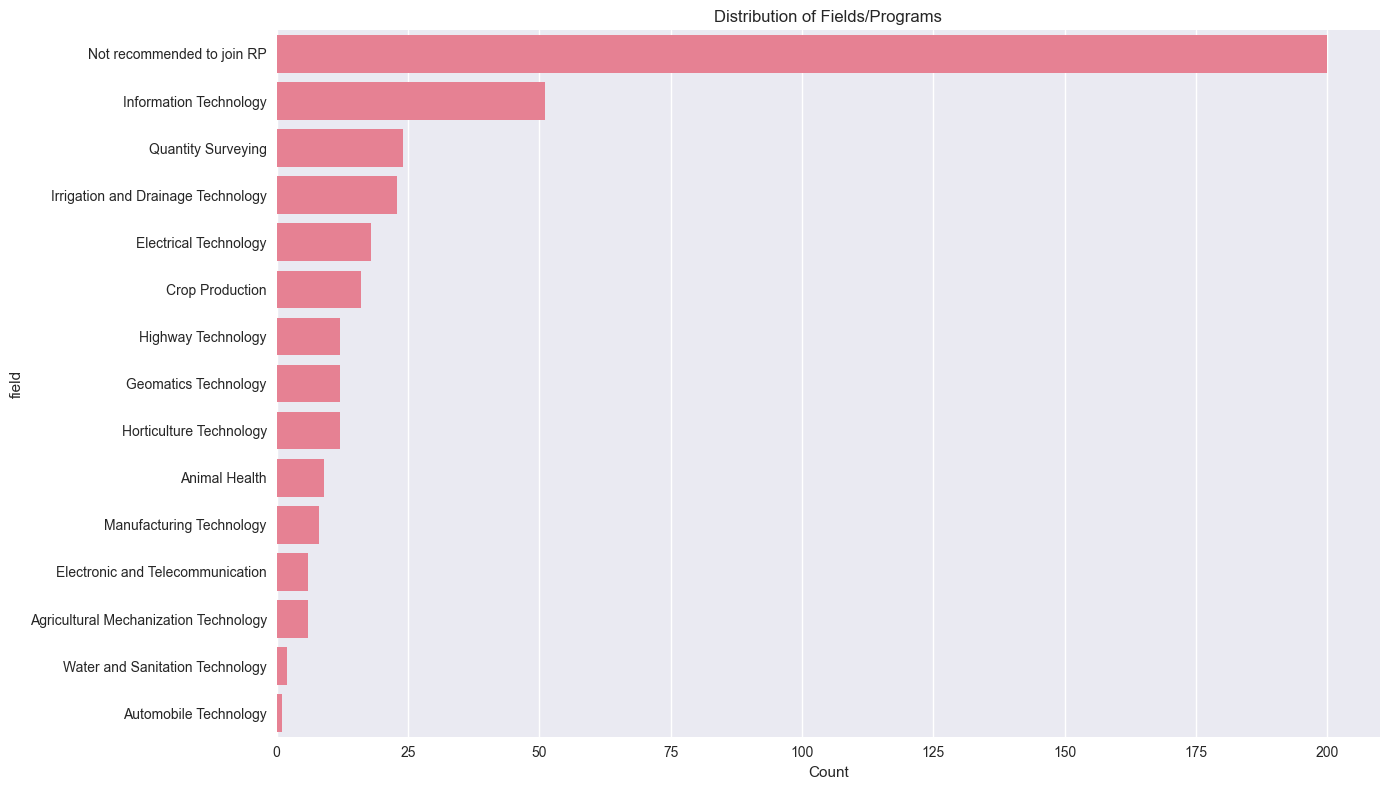

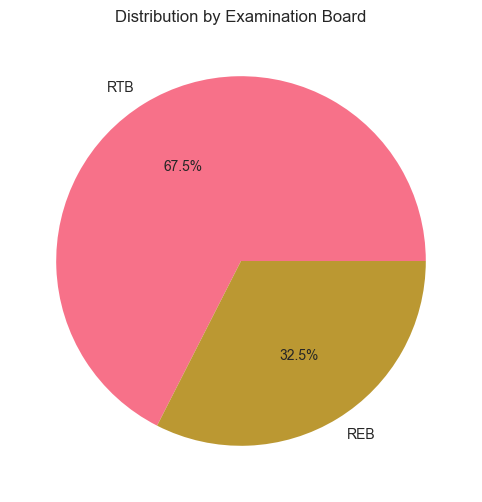

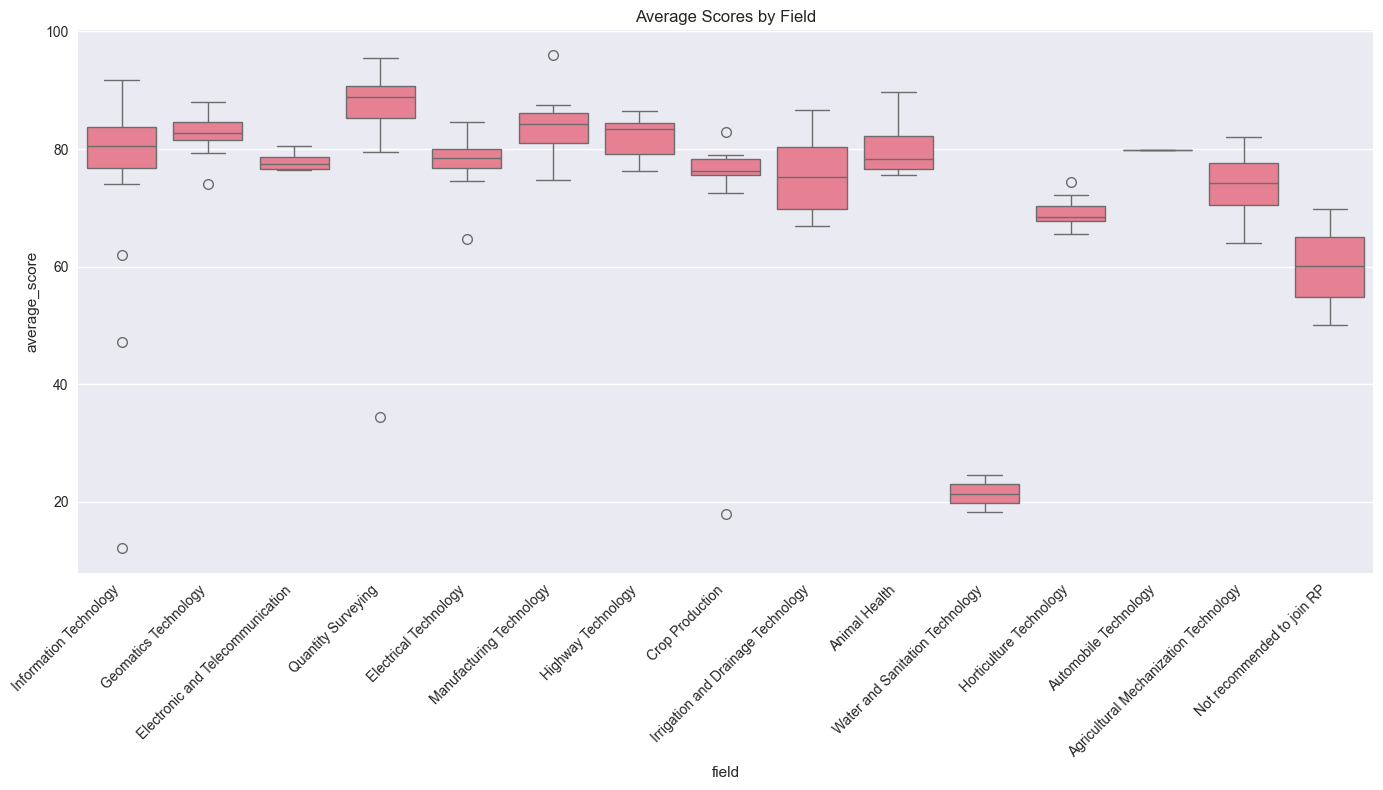

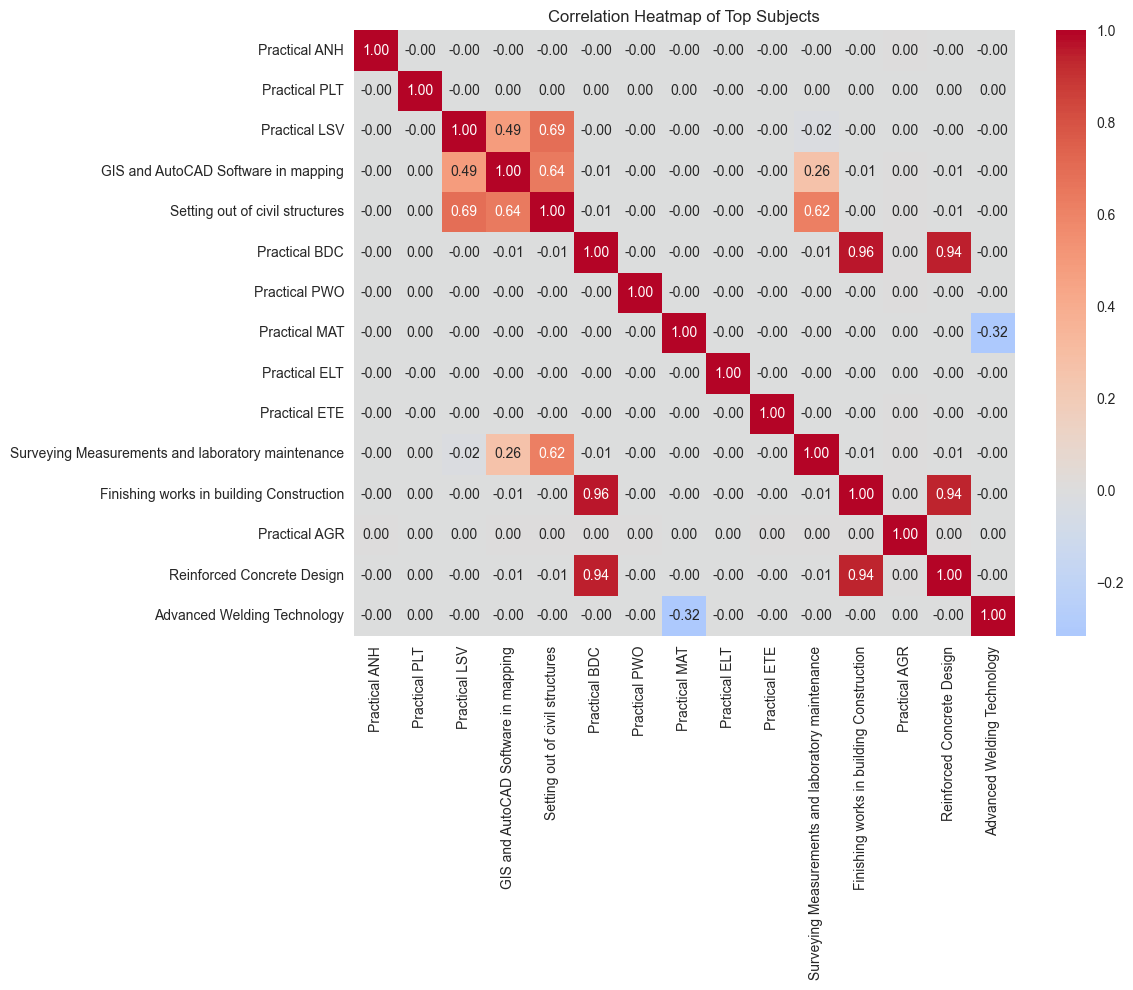


=== PREPARING DATA FOR MACHINE LEARNING ===

After removing rare fields, dataset shape: (397, 110)
Remaining fields: 13
Feature columns: 108
Samples: 397
Training set: 237 samples
Validation set: 80 samples
Test set: 80 samples

=== MODEL TRAINING AND EVALUATION ===

Training Random Forest...
Random Forest: Train=1.0000, Val=0.8875, Test=0.9125, CV=0.8610 (±0.0384)
Training K-Nearest Neighbors...
K-Nearest Neighbors: Train=0.8439, Val=0.7250, Test=0.7625, CV=0.7173 (±0.0216)
Training Logistic Regression...
Logistic Regression: Train=0.9958, Val=0.7250, Test=0.8250, CV=0.7637 (±0.0244)
Training Gradient Boosting...
Gradient Boosting: Train=1.0000, Val=0.8250, Test=0.8500, CV=0.8441 (±0.0403)
Training Decision Tree...
Decision Tree: Train=1.0000, Val=0.8875, Test=0.9000, CV=0.9199 (±0.0309)
Training Neural Network...
Neural Network: Train=0.9958, Val=0.7875, Test=0.8375, CV=0.7680 (±0.0351)
Training SVM...
SVM: Train=0.9325, Val=0.7375, Test=0.7375, CV=0.7344 (±0.0262)
Training Naive Ba

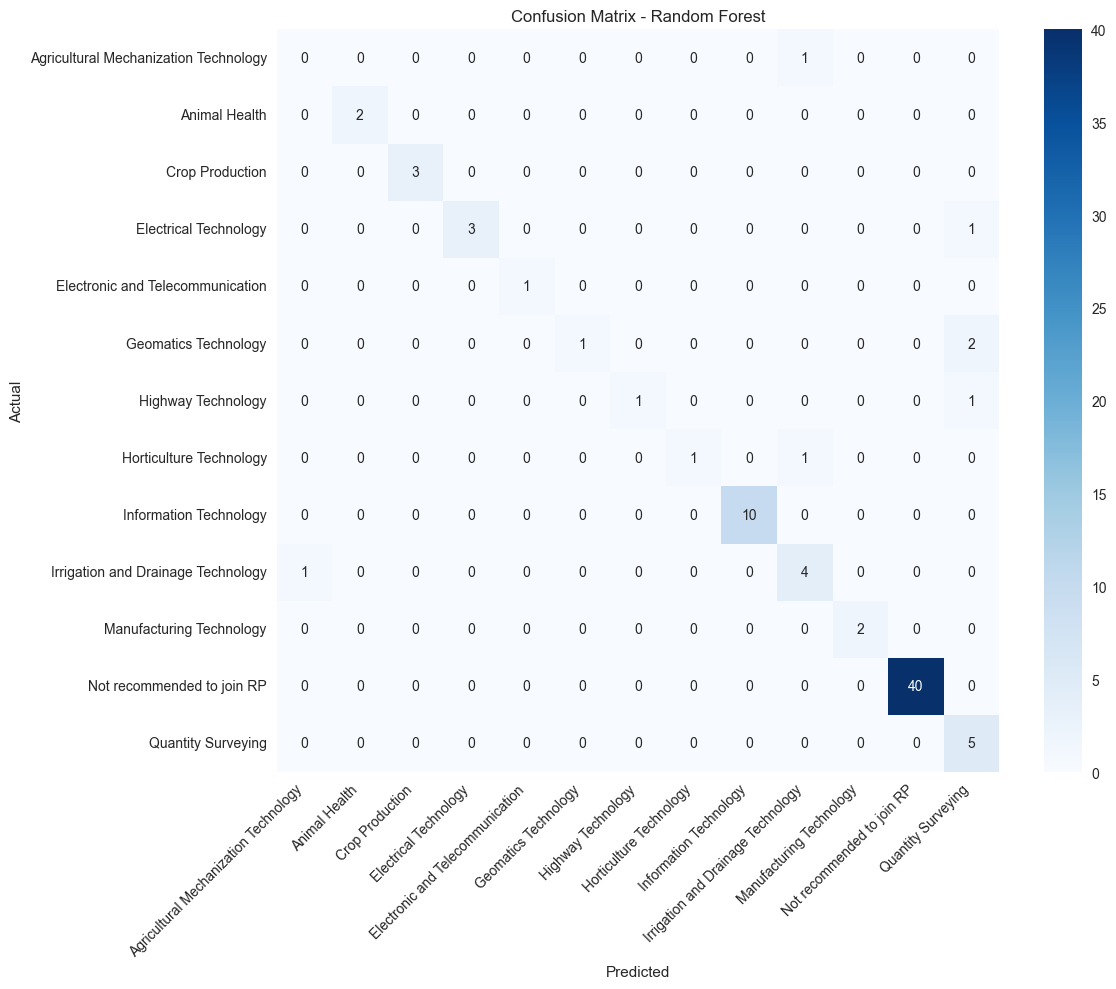

Classification Report:
                                       precision    recall  f1-score   support

Agricultural Mechanization Technology       0.00      0.00      0.00         1
                        Animal Health       1.00      1.00      1.00         2
                      Crop Production       1.00      1.00      1.00         3
                Electrical Technology       1.00      0.75      0.86         4
     Electronic and Telecommunication       1.00      1.00      1.00         1
                 Geomatics Technology       1.00      0.33      0.50         3
                   Highway Technology       1.00      0.50      0.67         2
              Horticulture Technology       1.00      0.50      0.67         2
               Information Technology       1.00      1.00      1.00        10
   Irrigation and Drainage Technology       0.67      0.80      0.73         5
             Manufacturing Technology       1.00      1.00      1.00         2
           Not recommended t

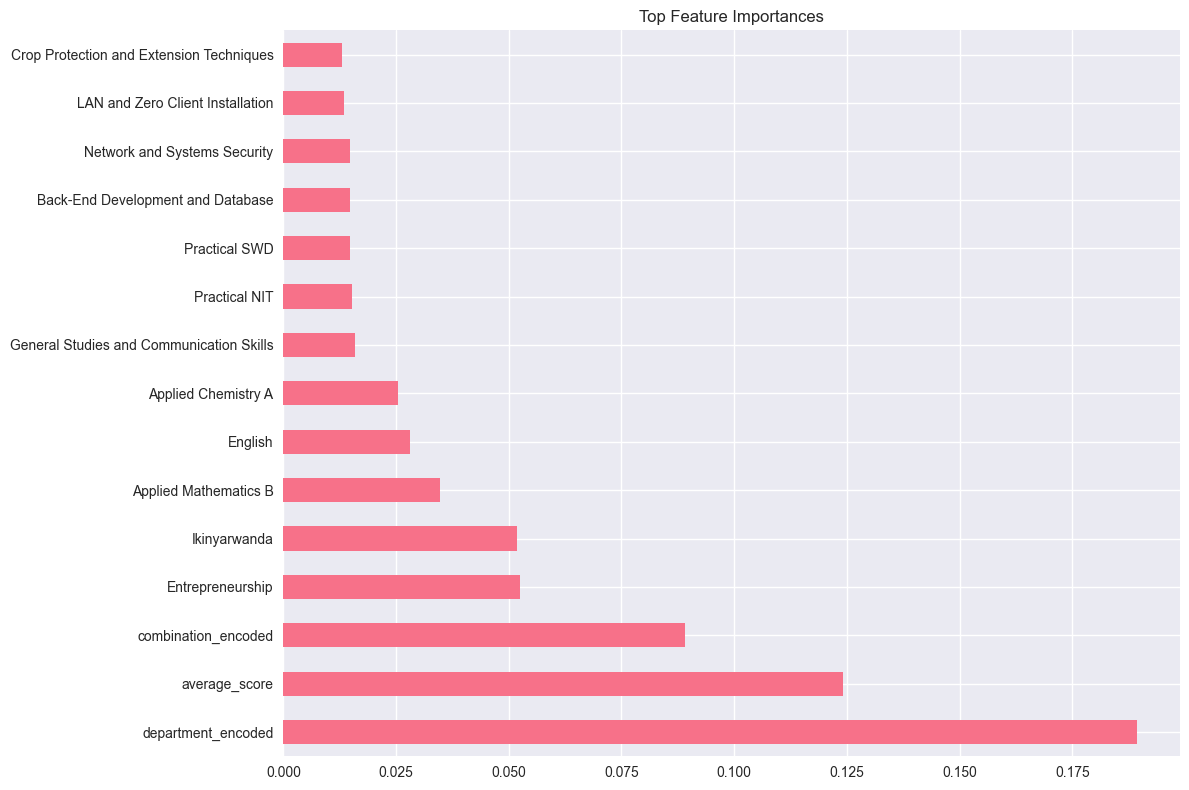

Top 10 most important features:
department_encoded                          0.189403
average_score                               0.124110
combination_encoded                         0.088998
Entrepreneurship                            0.052562
Ikinyarwanda                                0.051726
Applied Mathematics B                       0.034635
English                                     0.028126
Applied Chemistry A                         0.025445
General Studies and Communication Skills    0.015892
Practical NIT                               0.015324
dtype: float64

=== PREDICTION FUNCTION TEST ===

Test case: RTB student with NIT combination
Subject scores: {'Raw Animal Products Control and Livestock Extension': 92, 'Ikinyarwanda': 93, 'Farm Mechanization and Livestock Management': 83, 'Animal Diseases Prevention and Control': 80, 'Industrial electrical system installation and maintenance': 80}
Top 3 field recommendations:
1. Irrigation and Drainage Technology (confidence: 0.362)

In [1]:
# Create a comprehensive field recommendation system
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, f1_score, precision_score, recall_score,
                           roc_auc_score, precision_recall_curve)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_json("dataset/rp_merged_dataset_cleaned_marks_to_80_where_was_1.json")

print("Original dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Sample of marks column:")
print(df['marks'].head())

# Data Cleaning and Preparation
# =============================

# Extract all subject columns from marks - FIXED VERSION
subject_columns = []
for idx, row in df.iterrows():
    if isinstance(row['marks'], dict):
        subject_columns.extend(list(row['marks'].keys()))
    elif isinstance(row['marks'], str):
        try:
            # Try to parse as JSON if it's a string
            marks_dict = json.loads(row['marks'])
            subject_columns.extend(list(marks_dict.keys()))
        except:
            continue

subject_columns = list(set(subject_columns))
print(f"\nFound {len(subject_columns)} unique subjects:")
print(subject_columns[:10])  # Show first 10 subjects

# Create a new DataFrame with only necessary columns
df_clean = df[['examinationBoard', 'combination', 'department', 'field', 'yearStudy', 'average_score']].copy()

# Extract marks into separate columns
for subject in subject_columns:
    df_clean[subject] = np.nan

# Fill in the marks data
for idx, row in df.iterrows():
    marks_data = None
    if isinstance(row['marks'], dict):
        marks_data = row['marks']
    elif isinstance(row['marks'], str):
        try:
            marks_data = json.loads(row['marks'])
        except:
            continue
    
    if marks_data:
        for subject, score in marks_data.items():
            if subject in df_clean.columns and pd.notna(score):
                df_clean.at[idx, subject] = float(score)

print(f"Cleaned dataset shape: {df_clean.shape}")

# Handle 'Synthetic Course' - mark as 'Not recommended to join RP'
df_clean['field'] = df_clean['field'].apply(
    lambda x: 'Not recommended to join RP' if x == 'Synthetic Course' else x
)

# Check for missing values
print(f"\nMissing values per column:")
missing_values = df_clean.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0].head(20))

# Fill missing subject scores with column median (more robust than mean)
subject_cols = [col for col in df_clean.columns if col not in 
               ['examinationBoard', 'combination', 'department', 'field', 'yearStudy', 'average_score']]

print(f"\nFilling missing values for {len(subject_cols)} subject columns...")
for col in subject_cols:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

# Fill any remaining missing values
df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')

# Remove rows where target variable is missing
df_clean = df_clean.dropna(subset=['field'])

print(f"Final cleaned dataset shape: {df_clean.shape}")
print(f"Unique fields: {df_clean['field'].nunique()}")
print("\nField distribution:")
print(df_clean['field'].value_counts())

# Exploratory Data Analysis
# =========================

print("\n=== EXPLORATORY DATA ANALYSIS ===\n")

# 1. Distribution of fields
plt.figure(figsize=(14, 8))
field_counts = df_clean['field'].value_counts()
sns.barplot(x=field_counts.values, y=field_counts.index)
plt.title('Distribution of Fields/Programs')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# 2. Distribution by examination board
plt.figure(figsize=(10, 6))
board_counts = df_clean['examinationBoard'].value_counts()
plt.pie(board_counts.values, labels=board_counts.index, autopct='%1.1f%%')
plt.title('Distribution by Examination Board')
plt.show()

# 3. Average scores by field
plt.figure(figsize=(14, 8))
sns.boxplot(x='field', y='average_score', data=df_clean)
plt.xticks(rotation=45, ha='right')
plt.title('Average Scores by Field')
plt.tight_layout()
plt.show()

# 4. Correlation heatmap for top subjects
if len(subject_cols) > 0:
    # Select subjects with data and calculate means
    subject_data = df_clean[subject_cols].dropna(axis=1, how='all')
    if not subject_data.empty:
        subject_means = subject_data.mean().sort_values(ascending=False)
        top_subjects = subject_means.head(min(15, len(subject_means))).index.tolist()
        
        if len(top_subjects) > 1:
            plt.figure(figsize=(12, 10))
            correlation_matrix = df_clean[top_subjects].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
            plt.title('Correlation Heatmap of Top Subjects')
            plt.tight_layout()
            plt.show()

# Prepare data for machine learning
# ================================

print("\n=== PREPARING DATA FOR MACHINE LEARNING ===\n")

# Remove fields with very few samples (less than 5)
field_counts = df_clean['field'].value_counts()
valid_fields = field_counts[field_counts >= 5].index
df_clean = df_clean[df_clean['field'].isin(valid_fields)]

print(f"After removing rare fields, dataset shape: {df_clean.shape}")
print(f"Remaining fields: {df_clean['field'].nunique()}")

# Encode categorical variables
le_field = LabelEncoder()
le_board = LabelEncoder()
le_combination = LabelEncoder()
le_department = LabelEncoder()

df_clean['field_encoded'] = le_field.fit_transform(df_clean['field'])
df_clean['board_encoded'] = le_board.fit_transform(df_clean['examinationBoard'])
df_clean['combination_encoded'] = le_combination.fit_transform(df_clean['combination'])
df_clean['department_encoded'] = le_department.fit_transform(df_clean['department'])

# Define features and target
feature_cols = ['board_encoded', 'combination_encoded', 'department_encoded', 'average_score'] + subject_cols
feature_cols = [col for col in feature_cols if col in df_clean.columns]

X = df_clean[feature_cols]
y = df_clean['field_encoded']

print(f"Feature columns: {len(feature_cols)}")
print(f"Samples: {len(X)}")

# Check if we have enough data for ML
if len(X) < 50:
    print("Warning: Very small dataset. Results may not be reliable.")

# Split the data
if len(np.unique(y)) > 1:  # Check if we have multiple classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y if len(y) > len(np.unique(y)) else None
    )
    
    if len(X_train) > 20:  # Only create validation set if training set is large enough
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.25, random_state=42, 
            stratify=y_train if len(y_train) > len(np.unique(y_train)) else None
        )
    else:
        X_val, y_val = X_test, y_test
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Machine Learning Model Training
    # ==============================
    
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=min(5, len(X_train)//2)),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10)
    }
    
    # Add complex models only if we have enough data
    if len(X_train) > 100:
        models['Neural Network'] = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
        models['SVM'] = SVC(kernel='rbf', random_state=42)
        models['Naive Bayes'] = GaussianNB()
    
    results = {}
    
    print("\n=== MODEL TRAINING AND EVALUATION ===\n")
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        try:
            # Train model
            if name in ['K-Nearest Neighbors', 'Neural Network', 'Logistic Regression', 'SVM']:
                model.fit(X_train_scaled, y_train)
                train_pred = model.predict(X_train_scaled)
                val_pred = model.predict(X_val_scaled)
                test_pred = model.predict(X_test_scaled)
                
                X_cv = X_train_scaled
            else:
                model.fit(X_train, y_train)
                train_pred = model.predict(X_train)
                val_pred = model.predict(X_val)
                test_pred = model.predict(X_test)
                
                X_cv = X_train
            
            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)
            test_acc = accuracy_score(y_test, test_pred)
            
            # Cross-validation (only if we have enough samples)
            if len(X_train) > 10:
                cv_scores = cross_val_score(model, X_cv, y_train, cv=min(5, len(X_train)//10))
                cv_mean = cv_scores.mean()
                cv_std = cv_scores.std()
            else:
                cv_mean = val_acc
                cv_std = 0
            
            # Store results
            results[name] = {
                'model': model,
                'train_accuracy': train_acc,
                'val_accuracy': val_acc,
                'test_accuracy': test_acc,
                'cv_mean': cv_mean,
                'cv_std': cv_std,
                'predictions': test_pred
            }
            
            print(f"{name}: Train={train_acc:.4f}, Val={val_acc:.4f}, Test={test_acc:.4f}, CV={cv_mean:.4f} (±{cv_std:.4f})")
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            continue
    
    if results:
        # Display results in a table
        results_df = pd.DataFrame({
            'Model': list(results.keys()),
            'Train Accuracy': [results[name]['train_accuracy'] for name in results],
            'Validation Accuracy': [results[name]['val_accuracy'] for name in results],
            'Test Accuracy': [results[name]['test_accuracy'] for name in results],
            'CV Mean Score': [results[name]['cv_mean'] for name in results],
            'CV Std': [results[name]['cv_std'] for name in results]
        }).sort_values('Test Accuracy', ascending=False)
        
        print("\n=== FINAL RESULTS ===\n")
        print(results_df.round(4))
        
        # Identify best model
        best_model_name = results_df.iloc[0]['Model']
        best_model = results[best_model_name]['model']
        print(f"\nBest model: {best_model_name} with test accuracy: {results[best_model_name]['test_accuracy']:.4f}")
        
        # Detailed evaluation of best model
        print(f"\n=== DETAILED EVALUATION OF BEST MODEL ({best_model_name}) ===\n")
        
        # Confusion Matrix
        plt.figure(figsize=(12, 10))
        cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=le_field.classes_, 
                    yticklabels=le_field.classes_)
        plt.title(f'Confusion Matrix - {best_model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Classification Report
        print("Classification Report:")
        print(classification_report(y_test, results[best_model_name]['predictions'], 
                                   target_names=le_field.classes_))
        
        # Feature Importance (for tree-based models)
        if hasattr(best_model, 'feature_importances_'):
            plt.figure(figsize=(12, 8))
            feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
            top_features = feature_importance.nlargest(min(15, len(feature_importance)))
            top_features.plot(kind='barh')
            plt.title('Top Feature Importances')
            plt.tight_layout()
            plt.show()
            
            print("Top 10 most important features:")
            print(feature_importance.nlargest(10))
        
        # Create prediction function
        def recommend_field(examination_board, combination, subject_scores, department=None):
            """
            Recommend a field based on examination board, combination, and subject scores
            """
            try:
                # Calculate average score
                avg_score = np.mean(list(subject_scores.values()))
                
                # Create input data
                input_data = {
                    'average_score': avg_score,
                    'board_encoded': le_board.transform([examination_board])[0],
                    'combination_encoded': le_combination.transform([combination])[0],
                }
                
                # Add department if provided
                if department and department in le_department.classes_:
                    input_data['department_encoded'] = le_department.transform([department])[0]
                else:
                    # Use most common department
                    input_data['department_encoded'] = 0
                
                # Add subject scores
                for subject in subject_cols:
                    if subject in subject_scores:
                        input_data[subject] = subject_scores[subject]
                    else:
                        # Use median score for missing subjects
                        input_data[subject] = df_clean[subject].median()
                
                # Convert to DataFrame
                input_df = pd.DataFrame([input_data])
                
                # Ensure all columns are present and in correct order
                for col in X.columns:
                    if col not in input_df.columns:
                        input_df[col] = df_clean[col].median()
                
                input_df = input_df[X.columns]
                
                # Make prediction
                if best_model_name in ['K-Nearest Neighbors', 'Neural Network', 'Logistic Regression', 'SVM']:
                    input_scaled = scaler.transform(input_df)
                    prediction = best_model.predict(input_scaled)
                    probabilities = best_model.predict_proba(input_scaled)[0] if hasattr(best_model, 'predict_proba') else None
                else:
                    prediction = best_model.predict(input_df)
                    probabilities = best_model.predict_proba(input_df)[0] if hasattr(best_model, 'predict_proba') else None
                
                predicted_field = le_field.inverse_transform(prediction)[0]
                
                # Get top 3 recommendations if probabilities available
                recommendations = [(predicted_field, 1.0)]
                if probabilities is not None:
                    prob_df = pd.DataFrame({
                        'field': le_field.classes_,
                        'probability': probabilities
                    }).sort_values('probability', ascending=False)
                    
                    recommendations = [(row['field'], row['probability']) 
                                     for _, row in prob_df.head(3).iterrows()]
                
                return recommendations
                
            except Exception as e:
                return [("Error in prediction", 0.0)]
        
        # Test the prediction function
        print("\n=== PREDICTION FUNCTION TEST ===\n")
        
        # Get sample data for testing
        sample_board = df_clean['examinationBoard'].iloc[0]
        sample_combination = df_clean['combination'].iloc[0]
        
        # Create test scores
        test_scores = {}
        for subject in subject_cols[:5]:  # Use first 5 subjects for testing
            test_scores[subject] = np.random.randint(70, 95)
        
        print(f"Test case: {sample_board} student with {sample_combination} combination")
        print(f"Subject scores: {test_scores}")
        
        recommendations = recommend_field(sample_board, sample_combination, test_scores)
        
        print("Top 3 field recommendations:")
        for i, (field, prob) in enumerate(recommendations, 1):
            print(f"{i}. {field} (confidence: {prob:.3f})")
        
        print(f"\n=== FINAL SUMMARY ===")
        print(f"✓ Successfully processed {len(df)} records")
        print(f"✓ Extracted {len(subject_cols)} subjects from marks data")
        print(f"✓ Trained {len(results)} machine learning models")
        print(f"✓ Best model: {best_model_name} with {results[best_model_name]['test_accuracy']:.1%} accuracy")
        print(f"✓ Prediction function ready for new student recommendations")
        
    else:
        print("No models were successfully trained. Check your data and try again.")

else:
    print("Error: No variation in target variable. Cannot train models.")

In [2]:
recommendations = recommend_field('RTB', 'NIT', {      "Applied Mathematics B":80,
      "LAN and Zero Client Installation":80,
      "WAN and Fiber Optic Installation":80,
      "Cloud Computing":80,
      "Network and Systems Security":80,
      "Applied Physics B":80,
      "Network Systems Automation with Machine Learning":80,
      "Entrepreneurship":80,
      "IoT Systems Development and Installation":80,
      "English":80,
      "Ikinyarwanda":80,
      "Practical NIT":80})
# Returns: [('Computer Science', 0.85), ('Information Technology', 0.12), ('Engineering', 0.03)]
recommendations

[('Information Technology', 0.8484240150093808),
 ('Irrigation and Drainage Technology', 0.044394413174900976),
 ('Quantity Surveying', 0.029735772357723577)]

In [3]:
recommendations = recommend_field('RTB', 'SWD', {      "Applied Mathematics B":55,
      "Front-End Design and Development":46,
      "DevOps and Software Testing":50,
      "Back-End Development and Database":60,
      "Applied Physics B":81,
      "System Administration":70,
      "Entrepreneurship":68,
      "Web3 Development and Machine Learning":58,
      "English":87,
      "Ikinyarwanda":63,
      "Practical SWD":49})
# Returns: [('Computer Science', 0.85), ('Information Technology', 0.12), ('Engineering', 0.03)]
recommendations

[('Not recommended to join RP', 0.40342829789289736),
 ('Irrigation and Drainage Technology', 0.18521126846488994),
 ('Agricultural Mechanization Technology', 0.11791001716791294)]

In [4]:
# Print X_test data and compare predictions with actual fields
import pandas as pd

# After training the best model, add this code to compare predictions

if results:
    # Get the best model and its predictions
    best_model_name = results_df.iloc[0]['Model']
    best_model = results[best_model_name]['model']
    test_predictions = results[best_model_name]['predictions']
    
    # Create a comparison DataFrame
    comparison_df = pd.DataFrame()
    
    # Add X_test data (convert back to original feature names for readability)
    comparison_df = X_test.copy().reset_index(drop=True)
    
    # Decode categorical variables for better readability
    if 'board_encoded' in comparison_df.columns:
        comparison_df['examination_board'] = le_board.inverse_transform(comparison_df['board_encoded'])
        comparison_df = comparison_df.drop('board_encoded', axis=1)
    
    if 'combination_encoded' in comparison_df.columns:
        comparison_df['combination'] = le_combination.inverse_transform(comparison_df['combination_encoded'])
        comparison_df = comparison_df.drop('combination_encoded', axis=1)
    
    if 'department_encoded' in comparison_df.columns:
        comparison_df['department'] = le_department.inverse_transform(comparison_df['department_encoded'])
        comparison_df = comparison_df.drop('department_encoded', axis=1)
    
    # Add actual and predicted fields
    comparison_df['actual_field'] = le_field.inverse_transform(y_test)
    comparison_df['predicted_field'] = le_field.inverse_transform(test_predictions)
    
    # Add prediction accuracy
    comparison_df['correct_prediction'] = comparison_df['actual_field'] == comparison_df['predicted_field']
    
    print(f"\n=== TEST SET PREDICTIONS COMPARISON ===\n")
    print(f"Model: {best_model_name}")
    print(f"Total test samples: {len(comparison_df)}")
    print(f"Correct predictions: {comparison_df['correct_prediction'].sum()}")
    print(f"Accuracy: {comparison_df['correct_prediction'].mean():.4f}")
    
    print(f"\nFirst 20 test samples with predictions:")
    print("=" * 120)
    
    # Display columns in a more readable format
    display_columns = ['examination_board', 'combination', 'actual_field', 'predicted_field', 'correct_prediction']
    if 'department' in comparison_df.columns:
        display_columns.insert(2, 'department')
    if 'average_score' in comparison_df.columns:
        display_columns.insert(-3, 'average_score')
    
    # Show first 20 samples
    display_df = comparison_df[display_columns].head(20)
    
    for idx, row in display_df.iterrows():
        print(f"Sample {idx + 1}:")
        print(f"  Board: {row['examination_board']}")
        print(f"  Combination: {row['combination']}")
        if 'department' in row:
            print(f"  Department: {row['department']}")
        if 'average_score' in row:
            print(f"  Average Score: {row['average_score']:.2f}")
        print(f"  Actual Field: {row['actual_field']}")
        print(f"  Predicted Field: {row['predicted_field']}")
        print(f"  Correct: {'✓' if row['correct_prediction'] else '✗'}")
        print("-" * 80)
    
    # Show prediction accuracy by field
    print(f"\n=== PREDICTION ACCURACY BY FIELD ===\n")
    field_accuracy = comparison_df.groupby('actual_field').agg({
        'correct_prediction': ['count', 'sum', 'mean']
    }).round(4)
    field_accuracy.columns = ['Total_Samples', 'Correct_Predictions', 'Accuracy']
    field_accuracy = field_accuracy.sort_values('Accuracy', ascending=False)
    print(field_accuracy)
    
    # Show most common misclassifications
    print(f"\n=== MOST COMMON MISCLASSIFICATIONS ===\n")
    incorrect_predictions = comparison_df[comparison_df['correct_prediction'] == False]
    if len(incorrect_predictions) > 0:
        misclassifications = incorrect_predictions.groupby(['actual_field', 'predicted_field']).size().sort_values(ascending=False)
        print("Top 10 misclassifications (Actual → Predicted):")
        for (actual, predicted), count in misclassifications.head(10).items():
            print(f"  {actual} → {predicted}: {count} times")
    else:
        print("No misclassifications found!")
    
    # Copy X_test to clipboard format (optional)
    print(f"\n=== X_TEST DATA (COPY FORMAT) ===\n")
    print("X_test shape:", X_test.shape)
    print("\nX_test.head():")
    print(X_test.head().to_string())
    
    print(f"\ny_test (actual fields):")
    actual_fields = le_field.inverse_transform(y_test)
    for i, field in enumerate(actual_fields[:10]):
        print(f"  {i}: {field}")
    
    print(f"\nPredicted fields:")
    predicted_fields = le_field.inverse_transform(test_predictions)
    for i, field in enumerate(predicted_fields[:10]):
        print(f"  {i}: {field}")
    
    # Export detailed results to CSV (optional)
    comparison_df.to_csv('test_predictions_comparison.csv', index=False)
    print(f"\n✓ Detailed comparison saved to 'test_predictions_comparison.csv'")
    
    # Show feature importance for misclassified samples (if available) - FIXED VERSION
    if hasattr(best_model, 'feature_importances_'):
        print(f"\n=== FEATURE ANALYSIS FOR MISCLASSIFIED SAMPLES ===\n")
        if len(incorrect_predictions) > 0:
            print("Average feature values for misclassified samples:")
            
            # Reset X_test index to match comparison_df
            X_test_reset = X_test.reset_index(drop=True)
            
            # Get indices of misclassified and correct predictions
            misclassified_indices = incorrect_predictions.index.tolist()
            correct_indices = comparison_df[comparison_df['correct_prediction']].index.tolist()
            
            feature_cols_numeric = [col for col in X_test.columns if col in subject_cols or col == 'average_score']
            if feature_cols_numeric:
                misclassified_features = X_test_reset.loc[misclassified_indices][feature_cols_numeric].mean()
                correct_features = X_test_reset.loc[correct_indices][feature_cols_numeric].mean()
                
                feature_diff = pd.DataFrame({
                    'Misclassified_Avg': misclassified_features,
                    'Correct_Avg': correct_features,
                    'Difference': misclassified_features - correct_features
                }).sort_values('Difference', key=abs, ascending=False)
                
                print(feature_diff.head(10).round(2))
        else:
            print("No misclassified samples to analyze!")
    
    # Confusion matrix for detailed analysis
    print(f"\n=== DETAILED CONFUSION MATRIX ===\n")
    from sklearn.metrics import confusion_matrix
    cm_detailed = confusion_matrix(y_test, test_predictions)
    cm_df = pd.DataFrame(cm_detailed, 
                        index=le_field.classes_, 
                        columns=le_field.classes_)
    print("Confusion Matrix (rows=actual, columns=predicted):")
    print(cm_df.to_string())
    
    # Additional analysis: Show detailed breakdown of each test sample
    print(f"\n=== DETAILED BREAKDOWN OF ALL TEST SAMPLES ===\n")
    print("Sample breakdown with subject scores:")
    
    # Create X_test with readable column names for display
    X_test_display = X_test.copy().reset_index(drop=True)
    
    if 'board_encoded' in X_test_display.columns:
        X_test_display['examination_board'] = le_board.inverse_transform(X_test_display['board_encoded'])
        X_test_display = X_test_display.drop('board_encoded', axis=1)
    
    if 'combination_encoded' in X_test_display.columns:
        X_test_display['combination'] = le_combination.inverse_transform(X_test_display['combination_encoded'])
        X_test_display = X_test_display.drop('combination_encoded', axis=1)
    
    if 'department_encoded' in X_test_display.columns:
        X_test_display['department'] = le_department.inverse_transform(X_test_display['department_encoded'])
        X_test_display = X_test_display.drop('department_encoded', axis=1)
    
    # Add predictions and actual values
    X_test_display['actual_field'] = le_field.inverse_transform(y_test)
    X_test_display['predicted_field'] = le_field.inverse_transform(test_predictions)
    X_test_display['correct'] = X_test_display['actual_field'] == X_test_display['predicted_field']
    
    # Show first 10 samples with all their features
    print("First 10 test samples with all features:")
    for idx in range(min(10, len(X_test_display))):
        sample = X_test_display.iloc[idx]
        print(f"\n--- Sample {idx + 1} ---")
        print(f"Board: {sample.get('examination_board', 'N/A')}")
        print(f"Combination: {sample.get('combination', 'N/A')}")
        if 'department' in sample:
            print(f"Department: {sample['department']}")
        if 'average_score' in sample:
            print(f"Average Score: {sample['average_score']:.2f}")
        
        # Show top 5 subject scores
        subject_scores = {col: sample[col] for col in sample.index if col in subject_cols and pd.notna(sample[col])}
        if subject_scores:
            sorted_subjects = sorted(subject_scores.items(), key=lambda x: x[1], reverse=True)
            print("Top 5 subject scores:")
            for subject, score in sorted_subjects[:5]:
                print(f"  {subject}: {score:.1f}")
        
        print(f"Actual Field: {sample['actual_field']}")
        print(f"Predicted Field: {sample['predicted_field']}")
        print(f"Correct: {'✓' if sample['correct'] else '✗'}")
    
    # Summary statistics
    print(f"\n=== SUMMARY STATISTICS ===\n")
    print(f"Total test samples: {len(X_test)}")
    print(f"Total features used: {len(X_test.columns)}")
    print(f"Subject features: {len([col for col in X_test.columns if col in subject_cols])}")
    print(f"Categorical features: {len([col for col in X_test.columns if 'encoded' in col])}")
    print(f"Other features: {len([col for col in X_test.columns if col not in subject_cols and 'encoded' not in col])}")
    print(f"Unique actual fields in test set: {len(set(le_field.inverse_transform(y_test)))}")
    print(f"Unique predicted fields: {len(set(le_field.inverse_transform(test_predictions)))}")
    
    print(f"\nActual field distribution in test set:")
    actual_field_dist = pd.Series(le_field.inverse_transform(y_test)).value_counts()
    for field, count in actual_field_dist.items():
        print(f"  {field}: {count}")
    
    print(f"\nPredicted field distribution:")
    pred_field_dist = pd.Series(le_field.inverse_transform(test_predictions)).value_counts()
    for field, count in pred_field_dist.items():
        print(f"  {field}: {count}")


=== TEST SET PREDICTIONS COMPARISON ===

Model: Random Forest
Total test samples: 80
Correct predictions: 73
Accuracy: 0.9125

First 20 test samples with predictions:
Sample 1:
  Board: RTB
  Combination: MCB
  Department: Synthetic Department
  Average Score: 57.60
  Actual Field: Not recommended to join RP
  Predicted Field: Not recommended to join RP
  Correct: ✓
--------------------------------------------------------------------------------
Sample 2:
  Board: RTB
  Combination: MPC
  Department: Synthetic Department
  Average Score: 56.20
  Actual Field: Not recommended to join RP
  Predicted Field: Not recommended to join RP
  Correct: ✓
--------------------------------------------------------------------------------
Sample 3:
  Board: REB
  Combination: PCB
  Department: Agricultural Engineering
  Average Score: 68.00
  Actual Field: Irrigation and Drainage Technology
  Predicted Field: Agricultural Mechanization Technology
  Correct: ✗
-----------------------------------------